## Refraction: lens

The main role of this simulation is to look at the the **phase imprinting property of a lens** or **lens refraction**
see Sec. 2.15-2.18 of <a href="https://global.oup.com/academic/product/optics-f2f-9780198786795?cc=gb&lang=en&">Opticsf2f</a>.
We shall add rays which follow the **law of Ibn Sahl**, Sec. 2.7. This allows us to compare ray optics and
wave optics, at least for the case of a small lens.
For a simpler case of refraction, see also 
<a href="https://opticsf2f.github.io/Opticsf2f_CodeBook/PrismRefraction.html">
an example using a prism, PrismRefraction.ipynb</a>

The simulation makes use of some topics covered in later Chapters: For example, we shall propagate the electric 
field using the **hedgehog equation**, Sec. 6.4.
Also the input field is a **gaussian beam**, see  Sec. 11.3. However, we do not necessarily need to understanding exactly how 
the simulation is construction in order to understanding the basis properties of lens. 

If you just want to play with the **interactive figure** scroll to the bottom.

The Jupyter Notebook is LensRefraction.ipynb see

https://github.com/opticsf2f/Opticsf2f_CodeBook

pip install -U jupyter-book

<div class="interactive-start" onclick="initInteractiveCode()" title="This runs Python in your browser, allowing you local calculations">CLICK HERE TO ACTIVATE CODE CELLS</div>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.colors as colors
from numpy.fft import fft, ifft, fftshift

First we define some 2D functions. We use **GBeam** to plot a gaussian beam, **Line** to draw a ray and **Circle** to define the 
convex surface of a lens.

In [2]:
def Line(x,y,x1,y1,x2,y2,a):
    x0 = (x1+x2)/2
    y0 = (y1+y2)/2   
    rotation = -np.arctan((x1-x2)/(y1-y2+1e-8))
    b = np.sqrt((x1-x2)**2 + (y1-y2)**2) # length of line
    xa = (x-x0)*np.cos(rotation) + (y-y0)*np.sin(rotation)
    ya = (y-y0)*np.cos(rotation) - (x-x0)*np.sin(rotation)
    return (xa > (-a/2)) & (xa < (a/2)) & (ya > (-b/2)) & (ya < (b/2))

def GBeam(zb,yb,z0,y0,beamsize,angle):
    angle = angle
    za = (zb-z0)*np.cos(angle) + (yb-y0)*np.sin(angle)
    ya = (yb-y0)*np.cos(angle) - (zb-z0)*np.sin(angle)
    zR = np.pi*beamsize**2
    q = za-1.j*zR
    return (-1.j*zR*np.exp(2*np.pi*1.j*(za+ya*ya/(2*q)))/q) 

def Circle(x,y,x0,y0,r):
    xa = x-x0
    ya = y-y0
    return (xa*xa + ya*ya < (r*r)) 

Next we define a grid in units of the wavelength. $dy$ and $dz$ are the spatial resolution - 
$\lambda/40$ for the values given below. The $z$ axis will be the propagation direction.

In [3]:
zmin = 0 # z is the horizontal axis so like x in cartesian system
zmax = 40
ymin = -20   # vertical axis coould be x or y, call it y to agree with standard axes
ymax = 20
dz = 0.05
dy = 0.05
zoom = 1
Z, Y = np.mgrid[zmin/zoom:zmax/zoom:dz/zoom,ymin/zoom:ymax/zoom:dy/zoom]
z_pts, y_pts = np.shape(Z)

This is the corresponding (Fourier) $k$-space grid to be used in the hedgehog propagation.

In [4]:
kymax=1.0*np.pi/dy 
dky=2*kymax/y_pts
ky=np.arange(-kymax,kymax,dky) # fourier axis scaling
ky2=ky*ky
ky2c=ky2.astype('complex') #Notes on complex types http://www.scipy.org/NegativeSquareRoot
k=2.0*np.pi # k=2pi/lambda with lambda_0=1
k2=k*k
kz=np.sqrt(k2-ky2c)

This is the propagation phase the appears in the hedgehog equation.

In [5]:
ph=1.0j*kz*dz

We define region with higher refractive index to produce a plano-convex lens.

In [6]:
Radius = 18.0
Radius2=Radius*Radius
ZPos= zmax/2
YPos= 0
LensBack = 6
Lens = Circle(Z,Y,ZPos,YPos,Radius) * (Z < (LensBack))

Next, a function to draw rays.

In [7]:
def DrawRays(R,G,B,NRays,RaySep,RayWidth,BeamOffset,Index):
    for RayDisp in range (-NRays,NRays+1,1):
        ZR1 = 0
        YR1 = BeamOffset + RayDisp * RaySep
        if np.abs(YR1) < Radius:
            ZR2 = ZPos - np.sqrt(Radius**2 -  YR1**2)
            YR2 = np.sign(YR1)*np.sqrt(Radius**2 - (ZR2-ZPos)**2) # eqn or incomping ray 
            R += 0.2 * Line(Z,Y,ZR1,YR1,ZR2,YR2,RayWidth)
            Theta_i = np.arccos(-(ZR2-ZPos)/Radius) 
            Theta_t = np.arcsin(np.sin(Theta_i)/Index)
            BAngle2 = np.sign(YR1)*(Theta_t - Theta_i)            
            ZR3 = LensBack
            YR3 = (ZR3-ZR2)*np.tan(BAngle2) + YR2
            R += 0.2 * Line(Z,Y,ZR2,YR2,ZR3,YR3,RayWidth)
            BAngle3 = np.arcsin(np.clip(np.sin(BAngle2)*Index,-1.0,1.0))
            ZR4 = zmax
            YR4 = (ZR4-ZR3)*np.tan(BAngle3) + YR3
            R += 0.2 * Line(Z,Y,ZR3,YR3,ZR4,YR4,RayWidth)            
        else:
            ZR2 = zmax
            YR2 = YR1
            R += Line(Z,Y,ZR1,YR1,ZR2,YR2,0.1) 
    G += R
    B += R
    return R, G, B

The next cell is the core of the code. The first few lines initialise the grid, then we add the lens 
and a gaussian beam in the input plane. The hedgehog equation propagation starts on line 24.
Finally we add the results, either the electric field or the intensity into the RGB channels.

--- 0.7557756900787354 seconds ---


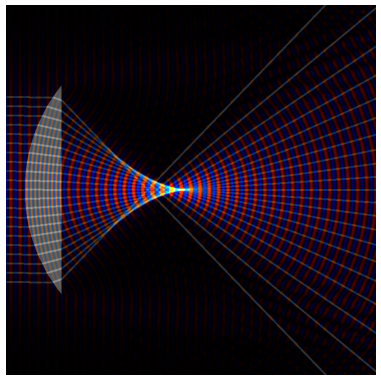

In [8]:
start_time = time.time()

Index = 2.2
BeamSize= 10
Rays = "Rays"
E_or_I = "Field"

R = np.zeros((z_pts,y_pts))
G = np.zeros((z_pts,y_pts))
B = np.zeros((z_pts,y_pts))

NR = np.zeros((z_pts,y_pts))
NR += (Index - 1)*Lens 
BAngle = 0*np.pi/180
BeamOffset = 0

if (Rays == "Rays"):        
    NRays = 10
    RaySep = 1 
    RayWidth = 0.2
    R, G, B = DrawRays(R, G, B, NRays, RaySep, RayWidth,0,Index )

E0 = GBeam(Z[0,:],Y[0,:],0,BeamOffset,BeamSize,BAngle)
b = fftshift(fft(E0))
for jj in range (0,z_pts): # propagat
        c = ifft(fftshift(b)) * np.exp(2.0j*np.pi*NR[jj,:]*dz)
        b = fftshift(fft(c)) * np.exp(1.0j*kz*dz)
        if (E_or_I == "Field"):
            R[jj,:] -=  0.5*c.real
            B[jj,:] +=  0.5*c.real
        if (E_or_I == "Intensity"):
            G[jj,:] +=  0.2*(abs(c)*abs(c))**0.5

fig, (ax1) = plt.subplots(1,1,figsize=(8, 8),dpi=60)

R+=0.3*(Index-1)*Lens # add lens to final image
G+=0.3*(Index-1)*Lens
B+=0.3*(Index-1)*Lens

br=1.0 
bg=1.0 
bb=1.0 

R=np.clip(br*R,0.0,1.0)
G=np.clip(bg*G,0.0,1.0)
B=np.clip(bb*B,0.0,1.0)
RGB=np.dstack((np.flipud(R.T), np.flipud(G.T), np.flipud(B.T))) # use transpose to swap image axes, flipud to origin at bottom left

ax1.imshow(RGB)
print("--- %s seconds ---" % (time.time() - start_time))
ax1.set_axis_off()

**Interactive version**

Now we want to make an interactive version where we can vary the refractive index, turn the rays on or off, visualise field 
or intensity.

First we make a function that returns the figure above for different input parameters.

The interactive figure is saved in 

https://github.com/opticsf2f/Opticsf2f_CodeBook/tree/main/assets


In [9]:
def LensFig(Index,BeamSize,Rays,E_or_I):
    R = np.zeros((z_pts,y_pts))
    G = np.zeros((z_pts,y_pts))
    B = np.zeros((z_pts,y_pts))
    NR = np.zeros((z_pts,y_pts))# refractive index
    NR += (Index - 1)*Lens # n-1 red 0.45
    BAngle = 0*np.pi/180
    BeamOffset = 0
    
    if (Rays == "Rays"):        
        NRays = 10
        RaySep = 1 
        RayWidth = 0.2
        R, G, B = DrawRays(R, G, B, NRays, RaySep, RayWidth,0,Index )
    
    E0 = GBeam(Z[0,:],Y[0,:],0,BeamOffset,BeamSize,BAngle)
    b = fftshift(fft(E0))
    for jj in range (0,z_pts): # propagat
            c = ifft(fftshift(b)) * np.exp(2.0j*np.pi*NR[jj,:]*dz)
            b = fftshift(fft(c)) * np.exp(1.0j*kz*dz)
            if (E_or_I == "Field"):
                R[jj,:] -=  0.5*c.real
                B[jj,:] +=  0.5*c.real
            if (E_or_I == "Intensity"):
                G[jj,:] +=  0.2*(abs(c)*abs(c))**0.5

    fig, (ax1) = plt.subplots(1,1,figsize=(8, 8),dpi=60)

    R+=0.3*(Index-1)*Lens # add lens to final image
    G+=0.3*(Index-1)*Lens
    B+=0.3*(Index-1)*Lens

    br=1.0 
    bg=1.0 
    bb=1.0 

    R=np.clip(br*R,0.0,1.0)
    G=np.clip(bg*G,0.0,1.0)
    B=np.clip(bb*B,0.0,1.0)
    RGB=np.dstack((np.flipud(R.T), np.flipud(G.T), np.flipud(B.T))) # use transpose to swap image axes, flipud to origin at bottom left

    ax1.imshow(RGB)
    ax1.set_axis_off()
    return fig, ""

# optional subplot to check whether we have done axis scaling correctly
#ax2.pcolormesh(Z,Y,B+G)

The next cell creates an interactive figure. This needs some additional code that is described
at 
https://github.com/nikolasibalic/Interactive-Publishing

The code is contained in the ifigures directory. You may need to add some fonts to your latex install.
Also install imagemick and comment out line

```
<policy domain="codes" rights="None" pattern="PDF"/>
```

Like this.

```
<!-- <policy domain="codes" rights="None" pattern="PDF"/> -->
```

near the bottom of the file

/etc/ImageMagick-6/policy.xml

To make an interactive figure we call the figure function for a range of parameters and save the plots in a html file.

There are many cools results in this simulation. A few of my favourites are:
    
1. The rays do not all converge on a single point due to **spherical aberrations**. The rays closer to the optical axis converge
at the focus.   
2. Looking at the field, we can see how the waves compress inside the lens. 
3. And how the lens imprints wavefront curvature.
4. Note how the focus of the gaussian beam (beam waist) is 'upstream' of the ray focus.
5. Note how the wavefronts are curved in the focal plane (indicated by the ray focus). 
6. Note how the field and intensity distributions are asymmetric upstream and downstream of the focus.

At least three of these, we miss if we only plot intensity!

In [10]:
from ifigures import *
from ifigures.my_plots import *

start_time = time.time()

figure_example1 = InteractiveFigure(LensFig,
                                    Index = RangeWidget(1.2, 2.2, 0.5),
                                    BeamSize = RangeWidget(5, 10, 5),
                                    Rays = RadioWidget(['No Rays', 'Rays']),
                                    E_or_I = RadioWidget(['Intensity', 'Field']),
)
figure_example1.saveStandaloneHTML("LensInteractive.html")

print("--- %s seconds ---" % (time.time() - start_time))
figure_example1.show()

--- 15.066281795501709 seconds ---
